<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/Training_and_Deploying_at_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import json
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt

##Checking GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    print("Disabling virtual GPU configuration...")
    tf.config.experimental.set_visible_devices([], 'GPU') # Disable virtual devices
    physical_gpus = tf.config.experimental.list_physical_devices('GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(physical_gpus)}, Logical GPUs: {len(logical_gpus)}")
  except RuntimeError as e:
    print("Error:", e)
else:
    print("No GPU found.")

Disabling virtual GPU configuration...
Physical GPUs: 1, Logical GPUs: 0


##Data Preparation

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

##Build and Training Base Model

In [ ]:
with tf.device('/CPU:0'):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=1e-2),
                  metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7200 - loss: 1.0945 - val_accuracy: 0.8988 - val_loss: 0.3721
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8983 - loss: 0.3684 - val_accuracy: 0.9180 - val_loss: 0.3013
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9124 - loss: 0.3096 - val_accuracy: 0.9248 - val_loss: 0.2690
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9208 - loss: 0.2814 - val_accuracy: 0.9316 - val_loss: 0.2452
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9273 - loss: 0.2592 - val_accuracy: 0.9362 - val_loss: 0.2284


##Save Model

In [ ]:
model_name = "my_mnist_model"
model_version = "0001"
model_dir = os.path.join("/content/", model_name, model_version)
print(f"\nMenyimpan model ke direktori: {model_dir}")
model.export(model_dir)

print("\nStruktur direktori SavedModel:")
!ls -lR {os.path.join("/content/", model_name)}


Menyimpan model ke direktori: /content/my_mnist_model/0001
Saved artifact at '/content/my_mnist_model/0001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  131941724027984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131941724751632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131941724027408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131941724751440: TensorSpec(shape=(), dtype=tf.resource, name=None)

Struktur direktori SavedModel:
/content/my_mnist_model:
total 4
drwxr-xr-x 4 root root 4096 Jun 14 22:49 0001

/content/my_mnist_model/0001:
total 48
drwxr-xr-x 2 root root  4096 Jun 14 22:32 assets
-rw-r--r-- 1 root root    57 Jun 14 22:49 fingerprint.pb
-rw-r--r-- 1 root root 33571 Jun 14 22:49 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 14 22:49 variables

##TensorFlow Serving

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   5742      0 --:--:-- --:--:-- --:--:--  5748
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jam

In [ ]:
os.environ["MODEL_DIR"] = os.path.join("/content/", model_name)

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=my_mnist_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
print("\nServer TF Serving sedang dimulai di background...")
time.sleep(5)


Server TF Serving sedang dimulai di background...


In [ ]:
X_new = X_test[:3]
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})
SERVER_URL = "http://localhost:8501/v1/models/my_mnist_model:predict"

Kueri berhasil!
Prediksi dari server: [7 2 1]
Label sebenarnya:   [7 2 1]


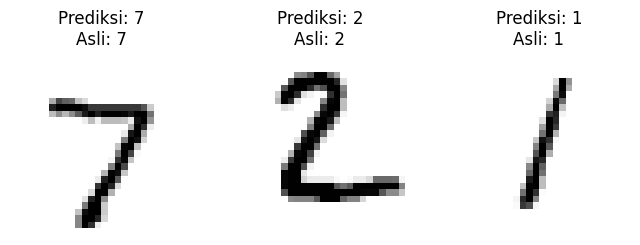

In [ ]:
try:
    response = requests.post(SERVER_URL, data=request_json)
    response.raise_for_status()
    response_data = response.json()

    print("Query berhasil!")
    y_proba = np.array(response_data["predictions"])
    y_pred = np.argmax(y_proba, axis=1)

    print(f"Prediksi dari server: {y_pred}")
    print(f"Label sebenarnya:   {y_test[:3]}")

    plt.figure(figsize=(8, 4))
    for index, image in enumerate(X_new):
        plt.subplot(1, 3, index + 1)
        plt.imshow(image.squeeze(), cmap="binary")
        plt.title(f"Prediksi: {y_pred[index]}\nAsli: {y_test[index]}")
        plt.axis("off")
    plt.show()

except Exception as e:
    print(f"\nError saat melakukan Query: {e}")
    print("\n--- Log Server (server.log) ---")
    !cat server.log

##Distribution Training with  MirroredStrategy

In [ ]:
distribution = tf.distribute.MirroredStrategy()
with distribution.scope():
    mirrored_model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10)
    ])
    optimizer = keras.optimizers.Adam()
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mirrored_model.compile(loss=loss_function,optimizer=optimizer,metrics=["accuracy"])

history_dist = mirrored_model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8684 - loss: 0.4680 - val_accuracy: 0.9558 - val_loss: 0.1536
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9599 - loss: 0.1390 - val_accuracy: 0.9678 - val_loss: 0.1124
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9719 - loss: 0.0920 - val_accuracy: 0.9718 - val_loss: 0.0951
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9802 - loss: 0.0670 - val_accuracy: 0.9718 - val_loss: 0.0908
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9838 - loss: 0.0524 - val_accuracy: 0.9766 - val_loss: 0.0756
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9880 - loss: 0.0410 - val_accuracy: 0.9772 - val_loss: 0.0788
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9902 - loss: 0.0330 - val_accuracy: 0.9754 - val_loss: 0.0901
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9914 - loss: 0.0

##Evaluate

In [ ]:
print("\nEvaluasi akhir model:")
loss, accuracy = mirrored_model.evaluate(X_test, y_test)
print(f"Loss Test: {loss:.4f}, Akurasi Test: {accuracy:.4f}")


Evaluasi akhir model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9742 - loss: 0.0938
Loss Test: 0.0817, Akurasi Test: 0.9782


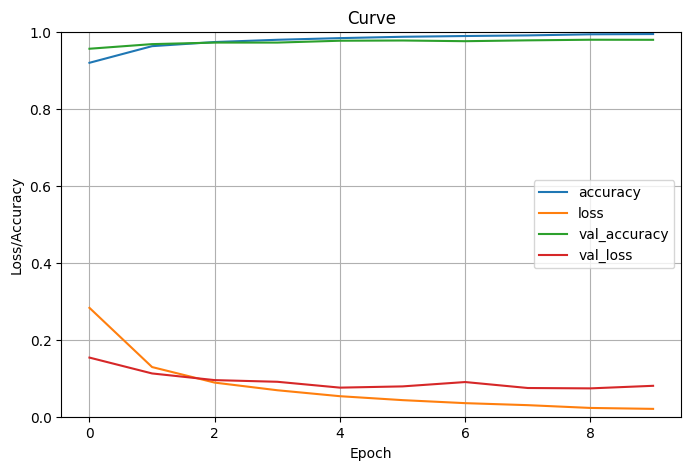

In [ ]:
pd.DataFrame(history_dist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()